#### Import libraries:

In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from porousmedialab.column import Column

#### Setting up the properties of time-space and create the domain:

In [2]:
t = 27 / 365
dx = 0.2
L = 40
phi = 0.8
dt = 1e-4
ftc = Column(L, dx, t, dt)

#### To make things interesting lets create not simple inital conditions for iron:

In [3]:
x = np.linspace(0, L, int(L / dx) + 1)
Fe3_init = np.zeros(x.size)
Fe3_init[x > 5] = 75
Fe3_init[x > 15] = 0
Fe3_init[x > 25] = 75
Fe3_init[x > 35] = 0

#### Adding species with names, diffusion coefficients, initial concentrations and boundary top and bottom conditions:

In [4]:
ftc.add_species(theta=phi, name='O2', D=368, init_conc=0, bc_top_value=0.231, bc_top_type='dirichlet', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=phi, name='TIC', D=320, init_conc=0, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=phi, name='Fe2', D=127, init_conc=0, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')

ftc.add_species(theta=1-phi, name='OM', D=1e-18, init_conc=15, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
ftc.add_species(theta=1-phi, name='FeOH3', D=1e-18, init_conc=Fe3_init, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')

ftc.add_species(theta=phi, name='CO2g', D=320, init_conc=0, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
ftc.henry_equilibrium('TIC', 'CO2g', 0.2*0.83)

#### Specify the constants used in the rates:

In [5]:
ftc.constants['k_OM'] = 1
ftc.constants['Km_O2'] = 1e-3
ftc.constants['Km_FeOH3'] = 2
ftc.constants['k8'] = 1.4e+5
ftc.constants['Q10'] = 4  ### added
ftc.constants['CF'] = (1-phi)/phi  ### conversion factor

### Simulate Temperature with thermal diffusivity coefficient 281000 and init and boundary temperature 5C:

In [6]:
ftc.add_species(theta=0.99, name='Temperature', D=281000, init_conc=5, bc_top_value=5., bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')

#### Add Q10 factor:

In [7]:
ftc.rates['R1'] = 'Q10**((Temperature-5)/10) * k_OM * OM * O2 / (Km_O2 + O2)'
ftc.rates['R2'] = 'Q10**((Temperature-5)/10) * k_OM * OM * FeOH3 / (Km_FeOH3 + FeOH3) * Km_O2 / (Km_O2 + O2)'
ftc.rates['R8'] = 'k8 * O2 * Fe2'

#### ODEs for specific species:

In [8]:
ftc.dcdt['OM'] = '-R1-R2'
ftc.dcdt['O2'] = '-R1-R8'
ftc.dcdt['FeOH3'] = '-4*R2+R8/CF'
ftc.dcdt['Fe2'] = '-R8+4*R2*CF'
ftc.dcdt['TIC'] = 'R1+R2*CF'

#### Because we are changing the boundary conditions for temperature and Oxygen (when T < 0 => no oxygen at the top), then we need to have a time loop:

In [9]:
# %pdb

In [10]:
for i in range(1, len(ftc.time)):
    day_of_bi_week = (ftc.time[i]*365) % 14

    if day_of_bi_week < 7:
        ftc.Temperature.bc_top_value = 5  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
    else:
        ftc.Temperature.bc_top_value = -10  + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)
        
    # when T < 0 => 0 flux of oxygen and CO2 at the top:
    if ftc.Temperature.bc_top_value < 0:
        ftc.change_boundary_conditions('O2', i, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
        ftc.change_boundary_conditions('CO2g', i, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
    else:
        ftc.change_boundary_conditions('O2', i, bc_top_value=0.231, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
        ftc.change_boundary_conditions('CO2g', i, bc_top_value=0, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
        
    # Integrate one timestep:
    ftc.integrate_one_timestep(i)

Boundary conditions changed for O2 at time 9.996297667530544e-05
Boundary conditions changed for CO2g at time 9.996297667530544e-05


Boundary conditions changed for O2 at time 0.019192891521658643
Boundary conditions changed for CO2g at time 0.019192891521658643


Boundary conditions changed for O2 at time 0.03838578304331729
Boundary conditions changed for CO2g at time 0.03838578304331729


Boundary conditions changed for O2 at time 0.05757867456497593
Boundary conditions changed for CO2g at time 0.05757867456497593


### What we did with temperature

<Axes: title={'center': 'Temperature at specific depths'}, xlabel='Time', ylabel='Temperature, C'>

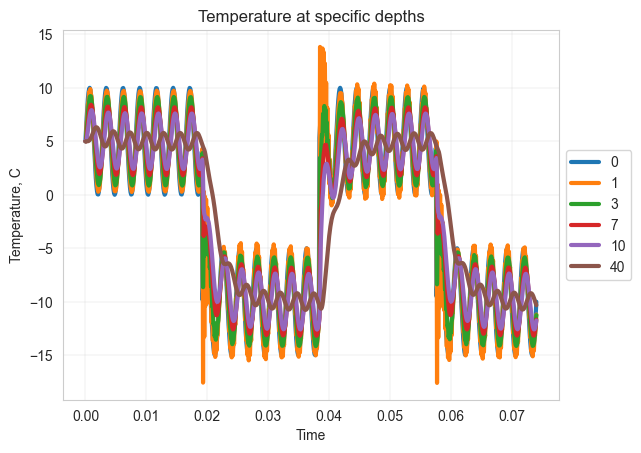

In [11]:
ftc.plot_depths("Temperature",[0,1,3,7,10,40])

### Concentrations of different species during the whole period of simulation:

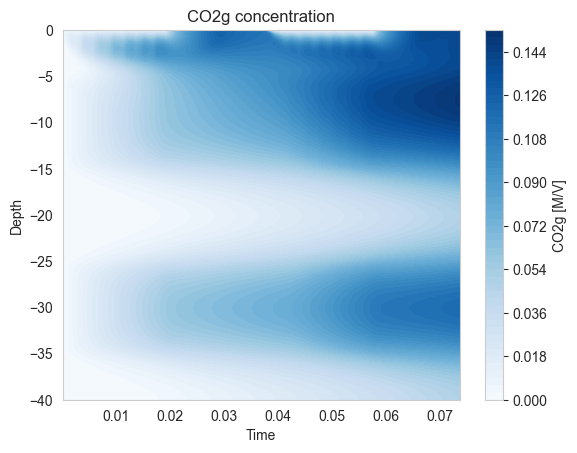

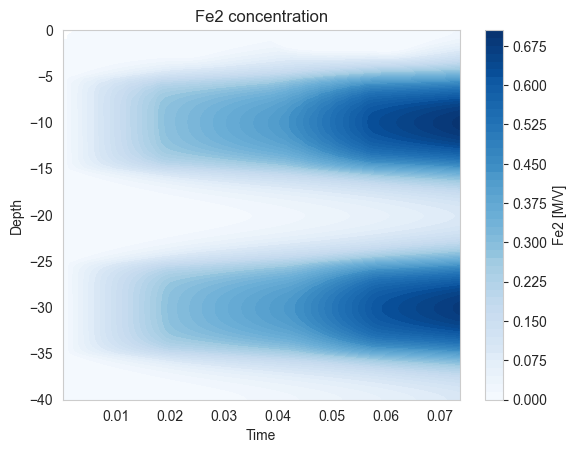

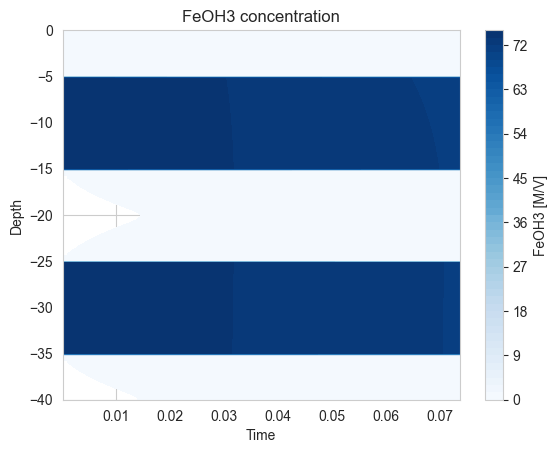

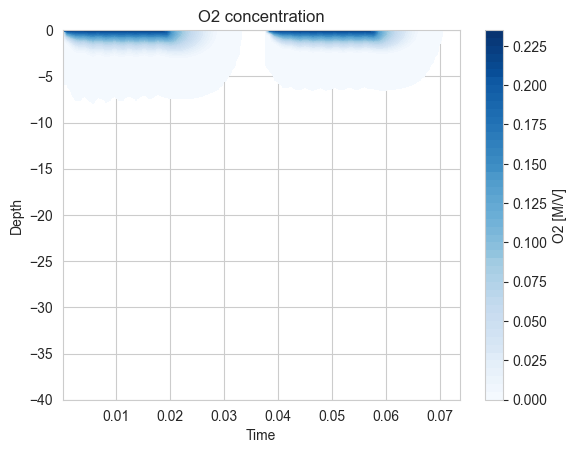

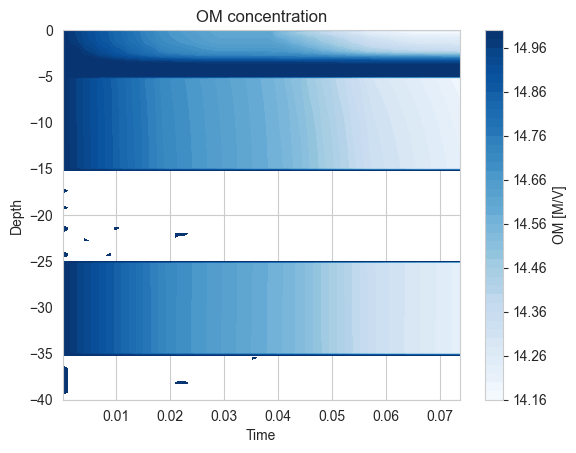

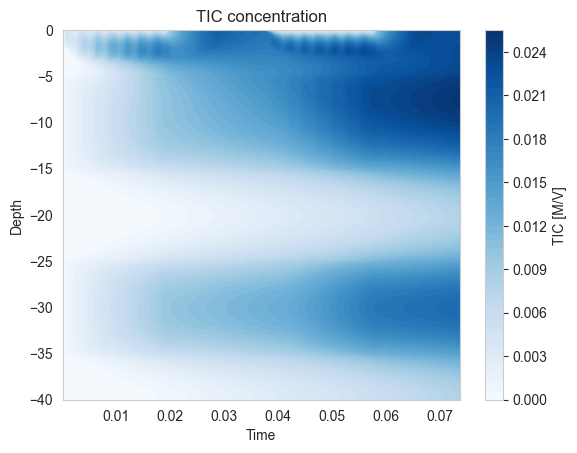

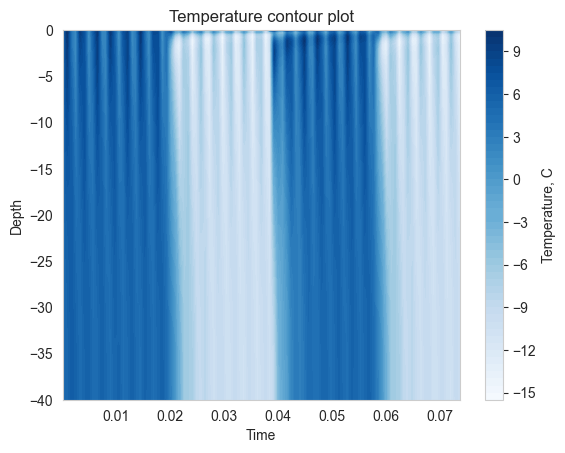

In [12]:
ftc.plot_contourplots()

### The rates of consumption and production of species:

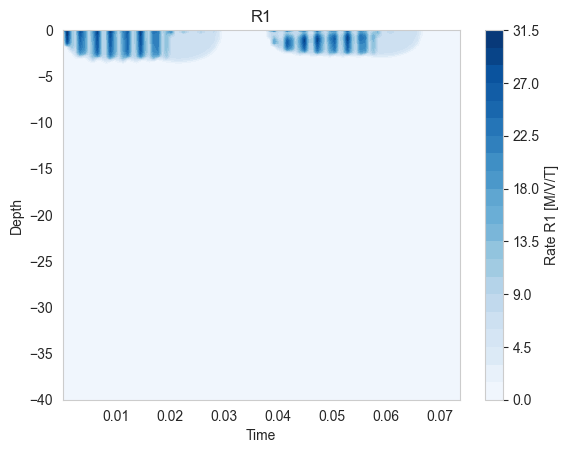

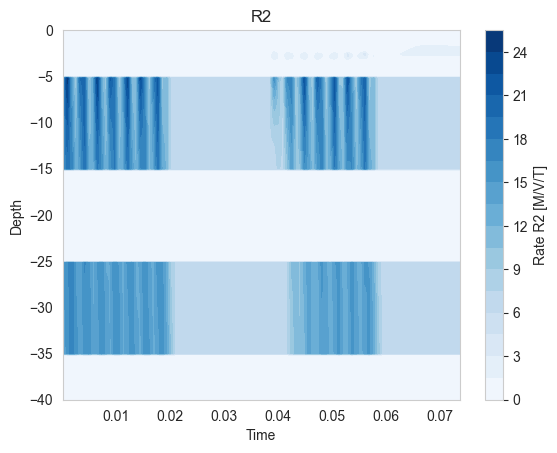

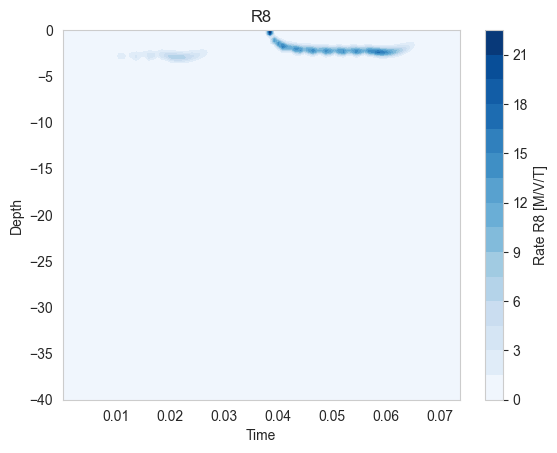

In [13]:
ftc.reconstruct_rates()
ftc.plot_contourplots_of_rates()

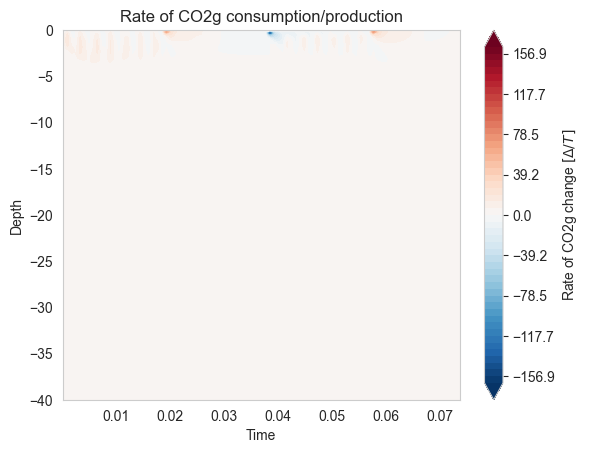

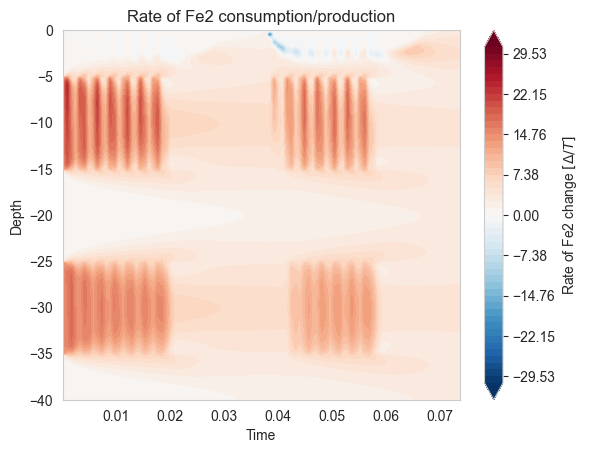

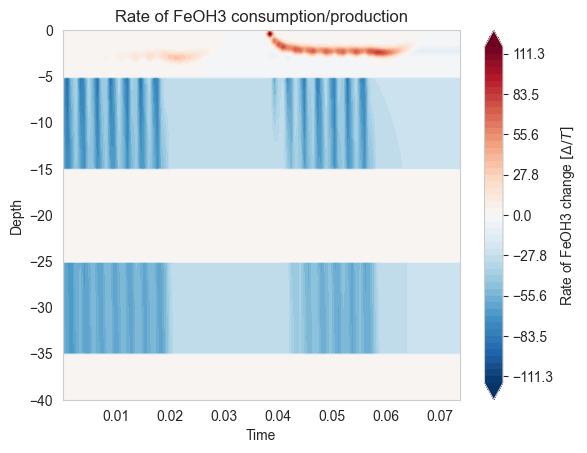

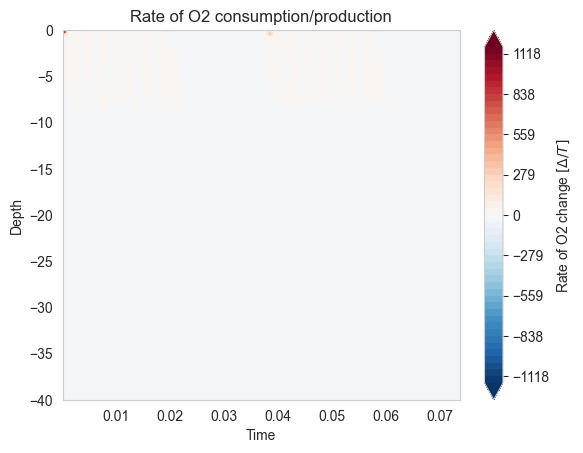

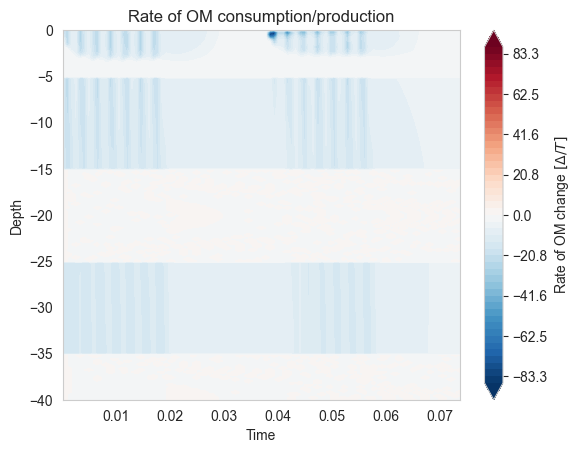

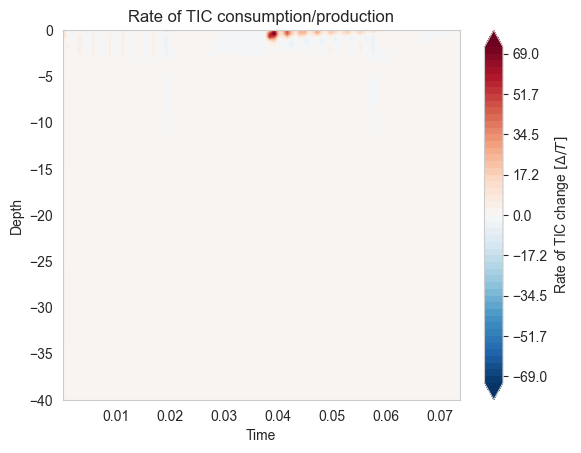

In [14]:
ftc.plot_contourplots_of_deltas()

### Profiles at the end of the simulation

<>:2: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:2: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
/var/folders/82/xbqx_sbj423_5fymhj9g7cvm0000gn/T/ipykernel_12024/1339102889.py:2: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  ftc.custom_plot(ftc.time*365, 1e+3*Fx*1e+4/365/24/60/60,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')


<Axes: xlabel='Days, [day]', ylabel='$F_{CO_2}$, $[\\mu mol$ $m^{-2}$ $s^{-1}]$'>

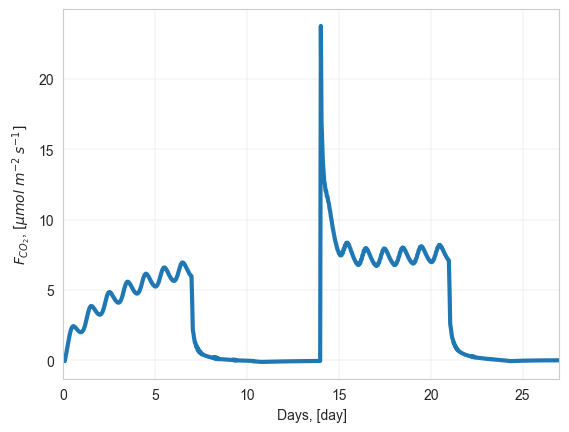

In [15]:
Fx = ftc.estimate_flux_at_top('CO2g')
ftc.custom_plot(ftc.time*365, 1e+3*Fx*1e+4/365/24/60/60,x_lbl='Days, [day]' , y_lbl='$F_{CO_2}$, $[\mu mol$ $m^{-2}$ $s^{-1}]$')

In [16]:
Fxco2 = 1e+3*Fx*1e+4/365/24/60/60
Fxco2nz = (ftc.time*365<7)*Fxco2 + ((ftc.time*365>14) & (ftc.time*365<21))*Fxco2

<>:14: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:14: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
/var/folders/82/xbqx_sbj423_5fymhj9g7cvm0000gn/T/ipykernel_12024/3804506527.py:14: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  ax1.set_ylabel('$CO_2(g)$ flux, $[\mu mol$ $m^{-2}$ $s^{-1}]$')


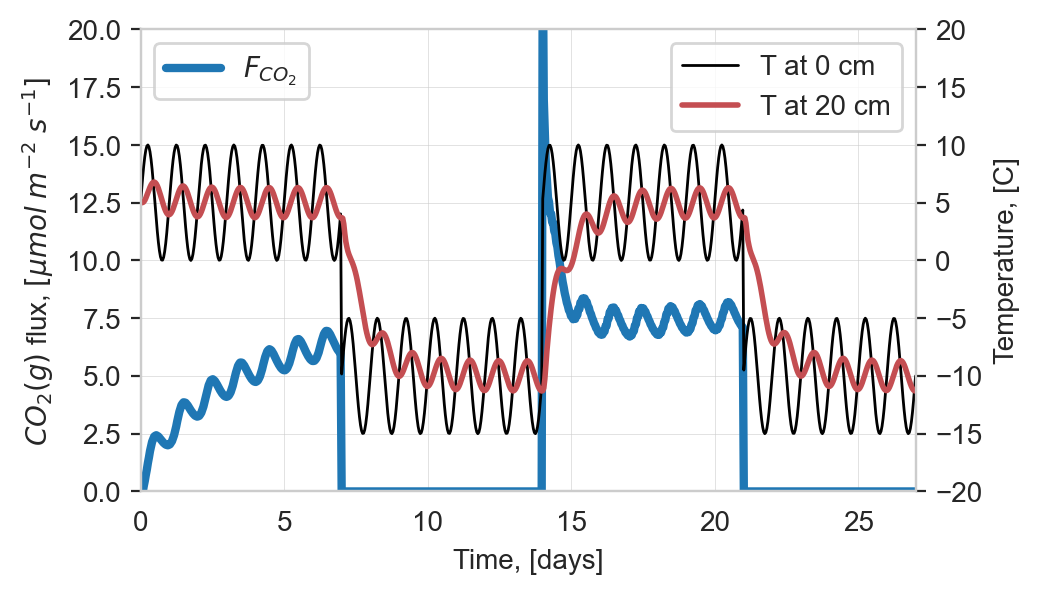

In [17]:
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(5,3), dpi=200)
ax2 = ax1.twinx()
ax1.plot(ftc.time*365, Fxco2nz, label='$F_{CO_2}$', lw=3)
ax2.plot(ftc.time*365, ftc.Temperature.concentration[0, :], 'k', lw=1, label='T at 0 cm')
ax2.plot(ftc.time*365, ftc.Temperature.concentration[100, :], ls='-', c=sns.color_palette("deep", 10)[3], lw=2, label='T at 20 cm')
# ax1.scatter(NO3_t, NO3, c=sns.color_palette("deep", 10)[0], lw=1)
ax2.grid(False)
ax1.grid(lw=0.2)
ax2.set_ylim(-20, 20)
ax1.set_xlim(0, 27)
ax1.set_xlabel('Time, [days]')
ax1.set_ylabel('$CO_2(g)$ flux, $[\mu mol$ $m^{-2}$ $s^{-1}]$')
ax2.set_ylabel('Temperature, [C]')
ax1.set_ylim(0, 20)
ax1.legend(frameon=1, loc=2)
ax2.legend(frameon=1, loc=1)

Text(0, 0.5, 'Fe2, [mM]')

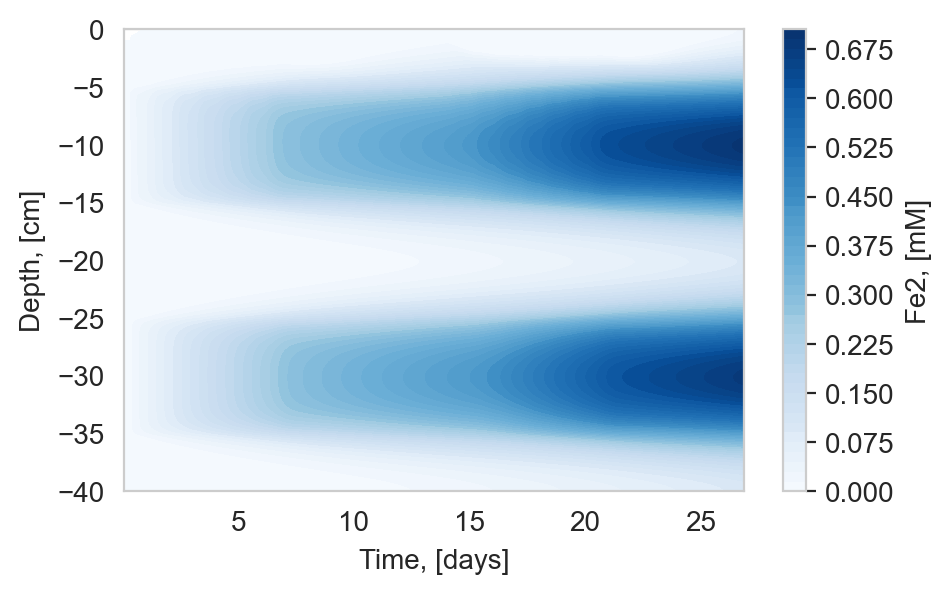

In [18]:
import math
from matplotlib.colors import ListedColormap
lab = ftc
element = 'Fe2'
labels=False
days=False
last_year=False
plt.figure(figsize=(5,3), dpi=200)
# plt.title('$Fe(II)$ concentration')
resoluion = 100
n = math.ceil(lab.time.size / resoluion)
if last_year:
    k = n - int(1 / lab.dt)
else:
    k = 1
if days:
    X, Y = np.meshgrid(lab.time[k::n] * 365, -lab.x)
    plt.xlabel('Time')
else:
    X, Y = np.meshgrid(lab.time[k::n] * 365, -lab.x)
    plt.xlabel('Time, [days]')
z = lab.species[element]['concentration'][:, k - 1:-1:n]
CS = plt.contourf(X, Y, z, 51, cmap=ListedColormap(
    sns.color_palette("Blues", 51)), origin='lower')
if labels:
    plt.clabel(CS, inline=1, fontsize=10, colors='w')
cbar = plt.colorbar(CS)
plt.ylabel('Depth, [cm]')
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
cbar.ax.set_ylabel('%s, [mM]' % element)

Text(0, 0.5, 'Rate R2, [$mM$ $d^{-1}$]')

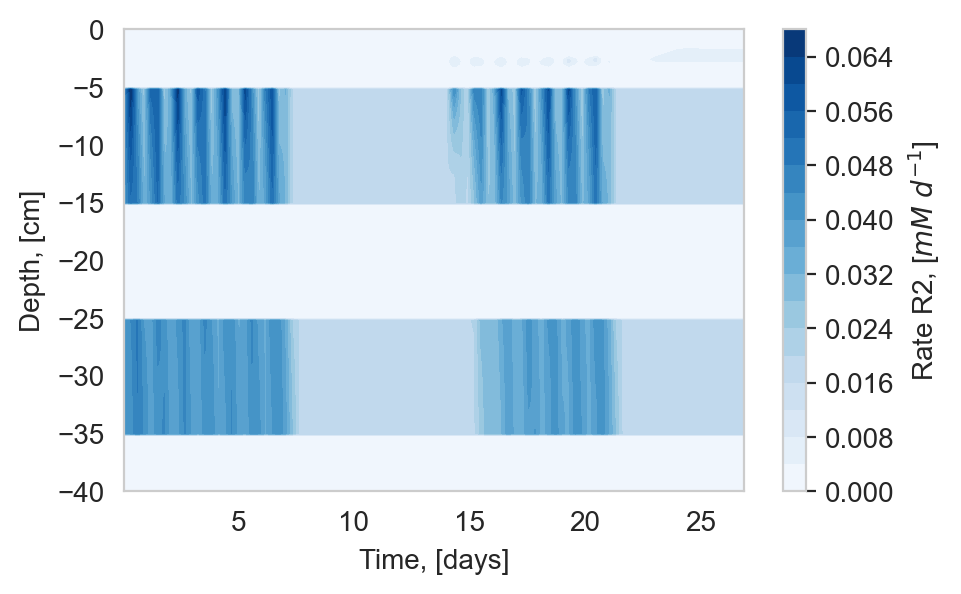

In [19]:
plt.figure(figsize=(5,3), dpi=200)
r='R2'
n = math.ceil(lab.time.size / resoluion)
if last_year:
    k = n - int(1 / lab.dt)
else:
    k = 1
z = lab.estimated_rates[r][:, k - 1:-1:n]
# lim = np.max(np.abs(z))
# lim = np.linspace(-lim - 0.1, +lim + 0.1, 51)
X, Y = np.meshgrid(lab.time[k::n], -lab.x)
plt.xlabel('Time, [days]')
CS = plt.contourf(X*365, Y, z/365, 20, cmap=ListedColormap(
    sns.color_palette("Blues", 51)))
if labels:
    plt.clabel(CS, inline=1, fontsize=10, colors='w')
cbar = plt.colorbar(CS)
plt.ylabel('Depth, [cm]')
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
cbar.ax.set_ylabel(r'Rate R2, [$mM$ $d^{-1}$]')

<>:22: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:22: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
/var/folders/82/xbqx_sbj423_5fymhj9g7cvm0000gn/T/ipykernel_12024/690946747.py:22: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
  cbar.ax.set_ylabel('$\Delta$ $Fe(OH)_3$ [$mM$ $d^{-1}$]')


Text(0, 0.5, '$\\Delta$ $Fe(OH)_3$ [$mM$ $d^{-1}$]')

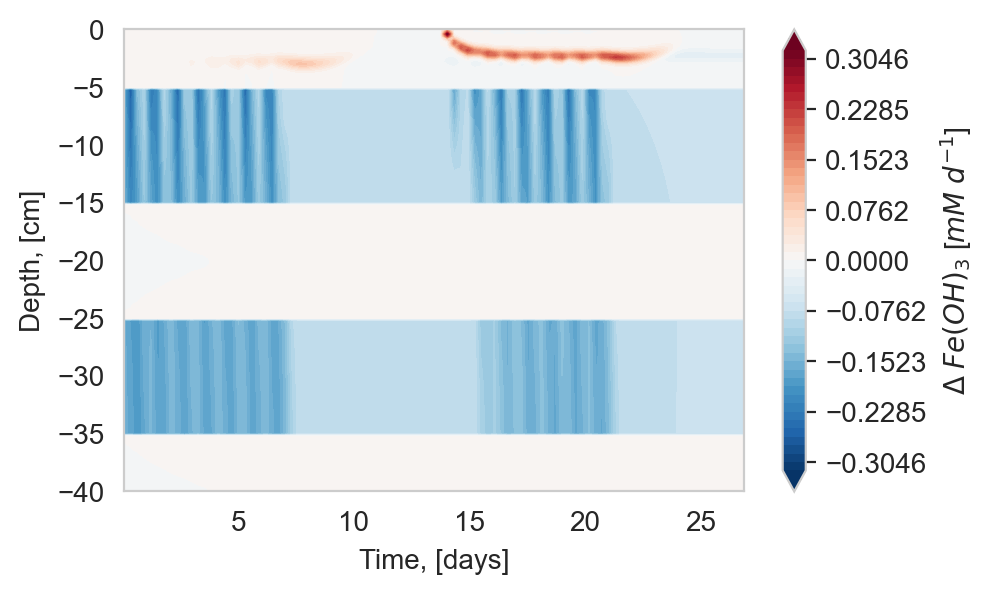

In [20]:
plt.figure(figsize=(5,3),dpi=200)
element='FeOH3'
resoluion = 100
n = math.ceil(lab.time.size / resoluion)
if last_year:
    k = n - int(1 / lab.dt)
else:
    k = 1
z = lab.species[element]['rates'][:, k - 1:-1:n]/365
lim = np.max(np.abs(z))
lim = np.linspace(-lim, +lim, 51)
X, Y = np.meshgrid(lab.time[k:-1:n], -lab.x)
plt.xlabel('Time, [days]')
CS = plt.contourf(X*365, Y, z, 20, cmap=ListedColormap(sns.color_palette(
    "RdBu_r", 101)), origin='lower', levels=lim, extend='both')
if labels:
    plt.clabel(CS, inline=1, fontsize=10, colors='w')
cbar = plt.colorbar(CS)
plt.ylabel('Depth, [cm]')
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
cbar.ax.set_ylabel('$\Delta$ $Fe(OH)_3$ [$mM$ $d^{-1}$]')